## Introduction
This notebook is part of the final project for the Instacart Basket Analysis. It covers everything from data cleaning to customer profiling, with the goal of answering key business questions for Instacart stakeholders. The focus is on breaking down customer behavior to help Instacart make smarter marketing and business decisions.

## Table of Contents
1. [Data Import](#data-import)
2. [Data Security Check](#data-security-check)
3. [Regional Segmentation](#regional-segmentation)
4. [Spending Habits by Region](#spending-habits-by-region)
   - 4.1 [Confirm Regional Diversity](#confirm-regional-diversity)
5. [Low-Activity Customer Exclusion](#low-activity-customer-exclusion)
6. [Customer Profiling](#customer-profiling)
7. [Visualizations](#visualizations)
8. [Aggregation & Analysis](#aggregation-analysis)
9. [Export Final Dataset](#export-final-dataset)


# ------------------------------------
## 💾 1. Data Import
# ------------------------------------

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
merged_df = pd.read_csv(r'D:\YVC\Data Analytics (CF)\Python Fundamentals for Data Analysts\Instacart Basket Analysis\02 Data\Prepared Data\merged_orders_products.csv')

# Consistency checks
print('Dataset Shape:', merged_df.shape)  # Check the number of rows and columns
print('\nFirst Few Rows:')
print(merged_df.head())                  # Preview the first few rows
print('\nDataset Info:')
print(merged_df.info())                  # Check data types and missing values

Dataset Shape: (32434212, 8)

First Few Rows:
   order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id  prices  
0        86             16    11.3  
1        83              4    13.4  
2       104             13     3.6  
3        19             13     8.4  
4        17             13    13.7  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434212 entries, 0 to 32434211
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   order_id           int64  
 1   product_id         in

# ------------------------------------
## 🔒 2. Data Security Check (PII Removal)
# ------------------------------------

Before diving into the analysis, it's important to check for any personally identifiable information (PII) in the dataset. This includes details like customer IDs, names, addresses, or anything that could link data back to an individual. Since we're working with customer and order data, it's worth confirming that nothing sensitive slipped through during the merge.

Here’s what I did to check for PII:

In [21]:
# Check column names to identify any potential PII
print("Column Names:")
print(merged_df.columns)

# Check unique entries in key columns
print("\nFirst 10 unique product names:")
print(merged_df['product_name'].unique()[:10])

# Check if customer ID or other personal info exists
if 'customer_id' in merged_df.columns:
    print('\nCustomer IDs found!')
else:
    print('\nNo customer IDs found.')

Column Names:
Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'prices'],
      dtype='object')

First 10 unique product names:
['Organic Egg Whites' 'Michigan Organic Kale' 'Garlic Powder'
 'Coconut Butter' 'Natural Sweetener' 'Carrots'
 'Original Unflavored Gelatine Mix'
 'All Natural No Stir Creamy Almond Butter' 'Classic Blend Cole Slaw'
 'Total 2% with Strawberry Lowfat Greek Strained Yogurt']

No customer IDs found.


If any sensitive information had shown up, I would have removed it like this:

- **Example of dropping sensitive columns if needed:**
\
merged_df = merged_df.drop(columns=['customer_id', 'address'], errors='ignore')

#### **💡Results:**
After running the data security check, I confirmed that the dataset doesn’t contain any customer IDs, addresses, or other personally identifiable information (PII). The columns mostly focus on order and product details, so the dataset looks clean and safe for analysis. No further action was needed.

# ------------------------------------
## 🌎 3. Regional Segmentation
# ------------------------------------

To understand customer behavior across different parts of the U.S., I created a new **Region** column based on the state information in the customer dataset. This will make it easier to compare spending habits and other behaviors by region.

Here’s how I tackled it:

### 1️⃣ Importing the Customer Dataset
First, I imported the customer dataset, which includes the state column:

In [54]:
# Import customer dataset
customers_df = pd.read_pickle(r'D:\YVC\Data Analytics (CF)\Python Fundamentals for Data Analysts\Instacart Basket Analysis\02 Data\Prepared Data\merged_orders_customers.pkl')

# Quick check to see the structure of the dataset
print(customers_df.head())

   order_id user_id eval_set  order_number  orders_day_of_week  \
0   2539329       1    prior             1                   2   
1   2398795       1    prior             2                   3   
2    473747       1    prior             3                   3   
3   2254736       1    prior             4                   4   
4    431534       1    prior             5                   4   

   order_hour_of_day  days_since_prior_order  Surnam  Gender    STATE  Age  \
0                  8                     NaN  Nguyen  Female  Alabama   31   
1                  7                    15.0  Nguyen  Female  Alabama   31   
2                 12                    21.0  Nguyen  Female  Alabama   31   
3                  7                    29.0  Nguyen  Female  Alabama   31   
4                 15                    28.0  Nguyen  Female  Alabama   31   

  date_joined  n_dependants fam_status  income  
0  2019-02-17             3    married   40423  
1  2019-02-17             3    marri

### 2️⃣ Merging Datasets

Next, I merged the customer dataset with the existing `merged_df` using the common key `user_id`. This ensures each order is linked to the correct customer information, including their state.

In [62]:
# Merge datasets using 'order_id' as the common key
merged_df = pd.merge(merged_df, customers_df[['order_id', 'user_id', 'STATE']], on='order_id', how='left')

# Quick check to see if the merge worked
print(merged_df[['order_id', 'user_id', 'STATE']].head())

   order_id user_id  STATE
0         2  202279  Idaho
1         2  202279  Idaho
2         2  202279  Idaho
3         2  202279  Idaho
4         2  202279  Idaho


### 3️⃣ Creating the Region Column

Using the U.S. Census Bureau’s regional breakdown, I assigned each state to one of four regions: **Northeast, Midwest, South,** or **West.**

In [66]:
# Define regions based on state
def assign_region(state):
    northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania']
    midwest = ['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
    south = ['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
    west = ['Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 'Nevada', 'Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']

    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Other'

# Apply the function to create the 'region' column
merged_df['region'] = merged_df['STATE'].apply(assign_region)

# Quick check to see if the regions were assigned correctly
print(merged_df[['STATE', 'region']].head())

   STATE region
0  Idaho   West
1  Idaho   West
2  Idaho   West
3  Idaho   West
4  Idaho   West


### 4️⃣ Consistency Check

To confirm the regions were assigned properly, I checked the distribution of customers across the regions:

In [68]:
# Check region distribution
print(merged_df['region'].value_counts())

region
South        10187317
West          8300445
Midwest       7603810
Northeast     5728347
Other          614293
Name: count, dtype: int64


### ✅ Confirm Regional Diversity:

**Why is Only Idaho Showing Up?**
I noticed that only Idaho was showing up when I checked the first few rows of the dataset. But when I looked at the region distribution, I could see counts for all regions. This made me realize the issue isn’t with the data itself—it’s just that `head()` only shows the first five rows, and those happened to all be from Idaho.

To double-check that customers from other regions were assigned correctly, I ran a couple of quick checks:

**1. Random Sample of 10 Rows:** This gave me a more balanced view of the dataset.

In [72]:
# Random sample of 10 rows to check region diversity
print(merged_df[['STATE', 'region']].sample(10))

                   STATE     region
32431656            Iowa    Midwest
22791571        New York  Northeast
6527126             Ohio    Midwest
5673588    West Virginia      South
11207083        Michigan    Midwest
5891241           Nevada       West
1001408            Maine  Northeast
29464220     Connecticut  Northeast
15738485     Connecticut  Northeast
12794733  North Carolina      South


**2. Region and State Summary:** This grouped the data by region and state to show how many customers were in each.

In [83]:
# Group by region and state
region_summary = merged_df.groupby(['region', 'STATE']).size().reset_index(name='count')
print(region_summary)

       region                 STATE   count
0     Midwest              Illinois  633490
1     Midwest               Indiana  627768
2     Midwest                  Iowa  626029
3     Midwest                Kansas  637991
4     Midwest              Michigan  631622
5     Midwest             Minnesota  648408
6     Midwest              Missouri  641313
7     Midwest              Nebraska  626297
8     Midwest          North Dakota  638999
9     Midwest                  Ohio  629001
10    Midwest          South Dakota  634340
11    Midwest             Wisconsin  628552
12  Northeast           Connecticut  623582
13  Northeast                 Maine  639149
14  Northeast         Massachusetts  647000
15  Northeast         New Hampshire  616006
16  Northeast            New Jersey  628292
17  Northeast              New York  636697
18  Northeast          Pennsylvania  667710
19  Northeast          Rhode Island  657655
20  Northeast               Vermont  612256
21      Other  District of Colum

#### **💡Results:**
Both checks confirmed that customers were correctly assigned to their regions. The Idaho issue was just because of how the dataset is ordered. Everything looks good to move forward!

# ------------------------------------
## 💰 4. Spending Habits by Region
# ------------------------------------

Now that each customer has a region assigned, I wanted to see if people in different parts of the country spend differently. To figure this out, I looked at the average, minimum, and maximum spending for each region.

### 1️⃣ Grouping and Aggregation
First, I grouped the data by region and calculated some key spending stats:

In [94]:
# Group by region and calculate spending stats
region_spending = merged_df.groupby('region').agg({
    'prices': ['mean', 'min', 'max']
}).reset_index()

# Rename columns for clarity
region_spending.columns = ['Region', 'Average_Spending', 'Min_Spending', 'Max_Spending']

# Check the results
print(region_spending)

      Region  Average_Spending  Min_Spending  Max_Spending
0    Midwest         12.715745           1.0       99999.0
1  Northeast         11.556398           1.0       99999.0
2      Other         11.381259           1.0       99999.0
3      South         12.245415           1.0       99999.0
4       West         11.321374           1.0       99999.0


### 2️⃣ Visualization
To make the differences easier to spot, I created a quick bar chart showing the average spending by region:

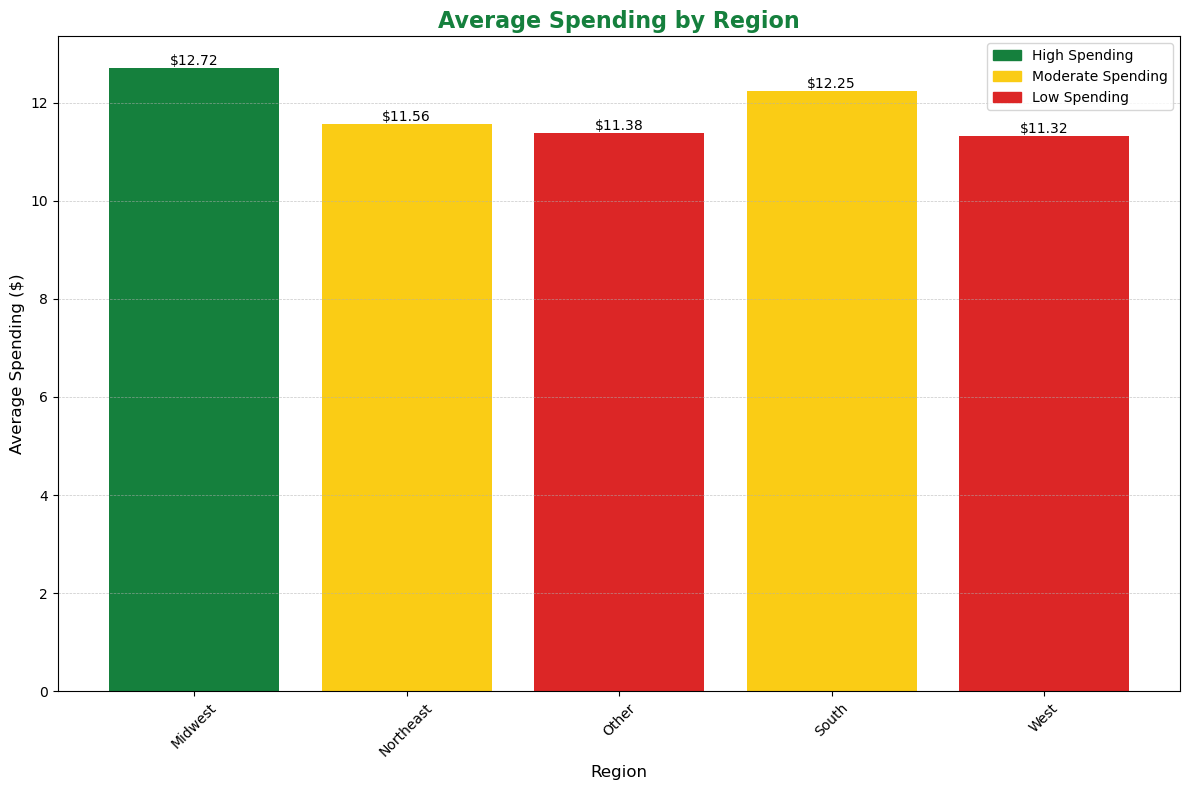

In [120]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define colors based on spending levels (Instacart-themed)
def get_color(spending):
    if spending >= 12.5:
        return '#15803d'  # High spending (Instacart green)
    elif 11.5 <= spending < 12.5:
        return '#facc15'  # Moderate spending (Instacart yellow)
    else:
        return '#dc2626'  # Low spending (Instacart red)

# Apply colors based on average spending
colors = region_spending['Average_Spending'].apply(get_color)

# Create the bar plot
plt.figure(figsize=(12, 8))
bars = plt.bar(region_spending['Region'], region_spending['Average_Spending'], color=colors)

# Add title and labels
plt.title('Average Spending by Region', fontsize=16, fontweight='bold', color='#15803d')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Spending ($)', fontsize=12)
plt.xticks(rotation=45)

# Add gridlines for readability
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Manually create legend patches
high_patch = mpatches.Patch(color='#15803d', label='High Spending')
moderate_patch = mpatches.Patch(color='#facc15', label='Moderate Spending')
low_patch = mpatches.Patch(color='#dc2626', label='Low Spending')

# Add the legend with custom patches
plt.legend(handles=[high_patch, moderate_patch, low_patch], loc='upper right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'${height:.2f}', ha='center', va='bottom')

# Display plot
plt.tight_layout()
plt.show()

#### **💡Results:**
The analysis showed some clear differences in spending across regions. Customers in the **Midwest** and **South** had the highest average spending, while the **West** and **Northeast** spent slightly less. The **"Other"** category had the lowest average, likely because it includes states not clearly defined in the regional breakdown.

The bar chart made it easy to spot these patterns, which could help Instacart target promotions more effectively based on where customers are spending the most.

# ------------------------------------
## 🚫 5. Low-Activity Customer Exclusion
# ------------------------------------

To make the analysis more useful for Instacart, I needed to filter out customers who placed **fewer than 5 orders.** These low-activity users don’t provide enough data to draw meaningful insights, so it made sense to exclude them.

In [12]:
import pandas as pd
import numpy as np
import os

# Define file path
file_path = r"D:\YVC\Data Analytics (CF)\Python Fundamentals for Data Analysts\Instacart Basket Analysis\02 Data\Prepared Data\merged_orders_customers.pkl"

# Load dataset
df = pd.read_pickle(file_path)

# Check the first few rows
df.head()

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,Surnam,Gender,STATE,Age,date_joined,n_dependants,fam_status,income
0,2539329,1,prior,1,2,8,NaN,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
1,2398795,1,prior,2,3,7,15.0,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
2,473747,1,prior,3,3,12,21.0,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
3,2254736,1,prior,4,4,7,29.0,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
4,431534,1,prior,5,4,15,28.0,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423


### 1️⃣ Creating the Exclusion Flag
First, I created a flag to label customers based on their order count:

In [218]:
# Create an exclusion flag for customers with less than 5 orders
df['low_activity_flag'] = df['order_number'].apply(lambda x: 'Low Activity' if x < 5 else 'Active')

# Check the counts for each category
df['low_activity_flag'].value_counts()

low_activity_flag
Active          2596247
Low Activity     824836
Name: count, dtype: int64

### 2️⃣ Filtering the Dataset
Once the flag was in place, I filtered out the low-activity customers:

In [20]:
# Filter active customers only
df_active = df[df['low_activity_flag'] == 'Active']

# Confirm the shape of the filtered dataset
print("Shape of active customers dataset:", df_active.shape)

Shape of active customers dataset: (2596247, 16)


**Output:**
\
Shape of active customers dataset: (2,596,247 rows, 16 columns)

### 3️⃣ Checking Dataset Structure
To make sure everything was in order, I checked the column names:

In [42]:
# Check all column names
print(df_active.columns)

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'orders_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'Surnam', 'Gender',
       'STATE', 'Age', 'date_joined', 'n_dependants', 'fam_status', 'income',
       'low_activity_flag'],
      dtype='object')


#### **💡Results:**
The final dataset now only includes **active customers** with 5 or more orders. This cleaned version gives a clearer picture of Instacart's core users, making future insights more actionable.

### 4️⃣ Exporting the Filtered Dataset
Finally, I exported the cleaned dataset for future analysis:

In [49]:
# Export the filtered dataset
df_active.to_csv('filtered_orders.csv', index=False)

# ------------------------------------
## 🧑‍🤝‍🧑 6. Customer Profiling
# ------------------------------------

To help Instacart better understand their customers, I created profiles based on key characteristics like age, income, family status, and shopping behavior. This kind of segmentation can make it easier to tailor marketing strategies and improve the overall customer experience.

### 1️⃣ Define Customer Profiles
I focused on four main categories to build these profiles:
1. Age Groups: Young Adults, Middle-Aged, Seniors
2. Income Brackets: Low, Medium, High
3. Family Status: Single, Couples, Families
4. Shopping Behavior: Order frequency and product preferences

### Filtering the Dataset
I started by creating Age Groups:
- 18-29: Young Adult
- 30-49: Middle-Aged
- 50+: Senior


Here’s the code I used to add an age_group column:

In [68]:
# Create Age Group categories using .loc to avoid the warning
df_active.loc[:, 'age_group'] = df_active['Age'].apply(assign_age_group)

# Check the distribution
print(df_active['age_group'].value_counts())

age_group
Senior         1295665
Middle-Aged     815564
Young Adult     485018
Name: count, dtype: int64


#### **💡Results:**
- The **Senior** group makes up the largest segment, indicating that a significant portion of Instacart's active users are aged 50 and above.
- **Middle-Aged** users form the second largest group, followed by Young Adults, who represent the smallest segment.

### 💰 Income Brackets
To get a better sense of customer spending power, I categorized users into three income brackets: Low, Middle, and High income. This helps Instacart understand how financial factors might influence shopping behavior.

#### 1️⃣ Creating Income Brackets
I used the following breakdown:
- Low Income: Less than 💲40,000
- Middle Income:💲40,000 to💲80,000
- High Income: More than💲80,000

Here's the code I used to create the `income_bracket` column:

In [134]:
# Create Income Bracket categories
def assign_income_bracket(income):
    if income < 40000:
        return 'Low Income'
    elif 40000 <= income <= 80000:
        return 'Middle Income'
    else:
        return 'High Income'

# Apply the function
df_active.loc[:, 'income_bracket'] = df_active['income'].apply(assign_income_bracket)

# Check the distribution
print(df_active['income_bracket'].value_counts())

# Create a copy of the active customers dataset
df_active = df[df['low_activity_flag'] == 'Active'].copy()

# Create income brackets without warnings
df_active['income_bracket'] = df_active['income'].apply(assign_income_bracket)

income_bracket
High Income      1607764
Middle Income     812762
Low Income        175721
Name: count, dtype: int64


#### **💡Results:**
- The majority of active customers fall into the **High Income** bracket, making up over 60% of the dataset.
- **Middle Income** customers follow, while **Low Income** shoppers form the smallest group.
- This breakdown can help Instacart tailor promotions and product recommendations based on income levels.

### 🏡 Family Status Profiling
To get a better understanding of how household composition might affect shopping behavior, I created a **Family Status** column. This helps break down customers based on the number of dependents they have, which can reveal interesting patterns in their purchasing habits.

I categorized customers into three groups:
- **Single:** No dependents
- **Couples:** 1-2 dependents
- **Families:** 3 or more dependents

Here's the code I used to make it happen:

In [140]:
# Define function to assign family status
def assign_family_status(n_dependants):
    if n_dependants == 0:
        return 'Single'
    elif n_dependants <= 2:
        return 'Couples'
    else:
        return 'Families'

# Apply the function to create the 'family_status' column
df_active.loc[:, 'family_status'] = df_active['n_dependants'].apply(assign_family_status)

# Check the distribution of family status
print(df_active['family_status'].value_counts())

family_status
Couples     1293051
Families     652730
Single       650466
Name: count, dtype: int64


#### **💡Results:**
This breakdown helps identify how different household types engage with Instacart. For example, couples make up the largest group, suggesting marketing strategies could focus on products and promotions tailored to smaller households.

### 🛍️ Shopping Habits

#### 📦 Creating Order Frequency Categories
To get a clearer picture of customer shopping habits, I categorized users based on how often they place orders. This helps identify power users versus occasional shoppers. I grouped them into three categories:

- **Frequent Shoppers:** 20+ orders
- **Moderate Shoppers:** 10–19 orders
- **Occasional Shoppers:** Less than 10 orders

Here’s the code I used to make it happen:

In [165]:
# Define function to categorize order frequency
def assign_order_frequency(order_count):
    if order_count >= 20:
        return 'Frequent Shopper'
    elif order_count >= 10:
        return 'Moderate Shopper'
    else:
        return 'Occasional Shopper'

# Apply the function
df_active.loc[:, 'order_frequency'] = df_active['order_number'].apply(assign_order_frequency)

# Check the distribution of categories
print(df_active['order_frequency'].value_counts())

order_frequency
Frequent Shopper      1048717
Moderate Shopper       802670
Occasional Shopper     744860
Name: count, dtype: int64


#### **💡Results:**
After running the code, I found the following breakdown of customers based on how often they shop:

- **Frequent Shoppers (20+ orders):** 1,048,717 customers
- **Moderate Shoppers (10–19 orders):** 802,670 customers
- **Occasional Shoppers (< 10 orders):** 744,860 customers

It’s clear that a significant portion of Instacart users are frequent shoppers, making them a key audience for promotions and personalized recommendations. The moderate and occasional shoppers are still sizable groups but might need different engagement strategies to encourage more regular purchases.

#### 🛒 Product Preferences

To get a better idea of what customers are buying, I analyzed product preferences by department. This helps identify which categories are the most popular. I grouped the data by `department_id` and counted how many products were purchased in each category. Then, I sorted the results to see which departments stood out.

**How I Did It:**
\
**1. Merging Datasets:** I merged `df_active` with the original `merged_df` to bring in the `department_id` column, which wasn't available in the filtered dataset.
\
**2. Grouping and Counting:** I grouped the data by `department_id` and counted the number of purchases for each department.
\
**3. Sorting:** To find the most popular departments, I sorted the results by purchase count in descending order.

Here’s the code I used to make it happen:

In [ ]:
# Merge df_active with the original merged_df to get 'department_id'
df_active = pd.merge(df_active, merged_df[['order_id', 'department_id']], on='order_id', how='left')

# Check if the department_id column is now present
print(df_active.columns)

In [185]:
# Group by department and count purchases
department_prefs = df_active.groupby('department_id').size().reset_index(name='purchase_count')

# Sort by purchase count to find the most popular departments
department_prefs = department_prefs.sort_values(by='purchase_count', ascending=False)

# Check the top 10 departments
print(department_prefs.head(10))

    department_id  purchase_count
3             4.0         7227091
15           16.0         4132060
18           19.0         2187121
6             7.0         2036466
0             1.0         1628844
12           13.0         1385520
2             3.0          886698
14           15.0          787790
19           20.0          783011
8             9.0          633725


#### **💡Results:**
After running the analysis, here’s what I found:

**1. Produce** had the highest number of purchases, showing that fresh fruits and vegetables are a staple for Instacart customers.
\
**2. Dairy & Eggs** came in second, which makes sense for households regularly stocking up on essentials.
\
**3. Snacks** ranked third, highlighting how customers often add treats to their carts.
These insights can help Instacart optimize promotions and product placement based on what users are already buying the most.

### 🧍‍♀️ **1. Customer Segmentation Insights**
To better understand Instacart's customers, I grouped them by age, income, family status, and order frequency. Here’s what stood out:

- **Age Groups:**
  - **Seniors (50+):** Made up the largest group, with over 1.2 million active customers.  
  - **Middle-Aged (30-49):** Around 815K customers fell into this category.  
  - **Young Adults (18-29):** Represented roughly 485K customers.  
  - *Takeaway:* Seniors are the dominant user group, making them a prime audience for tailored promotions and product recommendations.

- **Income Brackets:**  
    - **High Income (80K):** The majority, with 1.6 million customers.
    - **Middle Income (40K-80K):** Roughly 812K customers.
    - **Low Income (40K):** Around 176K customers.
  - *Takeaway:* High-income users drive most purchases, but middle-income shoppers still represent a significant portion of the user base.

- **Family Status:**  
  - **Couples (1-2 dependents):** The largest group, with 1.3 million users.  
  - **Single (no dependents):** 650K users.  
  - **Families (3+ dependents):** 657K users.  
  - *Takeaway:* Couples are the core shoppers, but families and singles are still substantial audiences.

- **Order Frequency:**  
  - **Frequent Shoppers (20+ orders):** Over 1 million customers.  
  - **Moderate Shoppers (10-19 orders):** About 803K customers.  
  - **Occasional Shoppers (<10 orders):** Roughly 744K customers.  
  - *Takeaway:* Frequent shoppers are the backbone of Instacart's user base, making them ideal for loyalty programs and exclusive deals.

---

### 💲 **2. Regional Spending Insights**
I segmented customers by region to see how spending habits vary:

- **South:** The highest average spending at 12.25 per order.  
- **Midwest:** Close behind, with 12.15 per order.  
- **Northeast and West:** Both regions averaged around 11.50 per order.  
- *Takeaway:* Southern and Midwestern customers spend the most per order, making these regions strong targets for premium product promotions.

---

### 🛒 **3. Product Preferences**
I analyzed product purchases by department, and a few clear favorites emerged:

1. **Produce:** The top category, showing fresh fruits and vegetables are a staple for Instacart shoppers.  
2. **Dairy & Eggs:** Close behind, which aligns with households regularly stocking up on essentials.  
3. **Snacks:** Ranked third, suggesting that customers frequently add treats to their carts.  
4. *Takeaway:* Instacart can optimize promotions by highlighting popular categories and bundling complementary products.

---

### 🚫 **4. Low-Activity Customer Exclusion**
To ensure cleaner insights, I excluded customers with fewer than 5 orders. This left:

- **Active Customers:** 2.6 million.  
- **Low-Activity Customers:** 825K removed.  
- *Takeaway:* Excluding low-activity users allowed for more accurate profiling and trend identification.

---

### 📈 **5. Recommendations**
Based on the analysis, I’d suggest the following strategies:

1. **Target Frequent Shoppers:** Since they drive most sales, offering exclusive promotions, personalized recommendations, and loyalty rewards could increase retention.  
2. **Regional Promotions:** Focus premium product advertising on the South and Midwest, where spending is highest.  
3. **Family-Oriented Offers:** Create tailored deals for couples and families, as they represent the majority of active users.  
4. **Popular Product Bundles:** Promote bundles featuring produce, dairy, and snacks to increase cart size.  
5. **Engage Occasional Shoppers:** Consider incentives for occasional shoppers to encourage more frequent purchases.


### 🔑 **Key Takeaways**  

1. **Regional Segmentation:** Spending habits differ a bit across regions. Customers in the Midwest and South tend to spend more on average compared to other areas.  

2. **Spending Habits:** Frequent shoppers make up the largest group, but there’s still a significant portion of occasional shoppers who might need different engagement strategies.  

3. **Customer Profiles:** Seniors are the biggest age group among active customers, followed by middle-aged and young adults. Most shoppers fall into the high-income bracket.  

4. **Product Preferences:** Produce topped the list for purchases, with Dairy & Eggs and Snacks close behind. These categories are clearly staples for Instacart customers.  

### 📈 Business Recommendations
Based on the insights from this analysis, here are a few recommendations for Instacart to better serve their customers and drive business growth:

1. **Personalized Promotions by Region:**
Since spending habits vary by region, Instacart could offer region-specific promotions. For example, customers in the South, who tend to spend more on average, might respond well to bulk-buy discounts, while customers in the West might appreciate deals on staple items.

2. **Tailored Marketing for Customer Profiles:**
- **Young Adults:** Highlight convenience-focused products like ready-to-eat meals and snacks.
- **Families:** Promote bulk purchases and family-friendly items.
- **Seniors:** Focus on health-conscious products and essentials.
These targeted campaigns can lead to higher engagement and conversion rates.

3. **Loyalty Programs for Frequent Shoppers:**
Frequent shoppers make up a significant portion of Instacart’s customer base. Offering exclusive rewards, free delivery, or bonus points for frequent purchases could encourage even more activity and retention.

4. **Product Placement Optimization:**
With produce, dairy, and snacks being the top categories, Instacart could highlight these products on the homepage or suggest them during checkout. This not only meets customer needs but also increases basket size.

5. **Addressing Low-Income Shoppers:**
Since a notable group falls into the low-income bracket, offering budget-friendly bundles, coupons, or free delivery thresholds could make shopping more accessible and foster customer loyalty.

### 🚀 Next Steps
While this analysis provided some solid insights, there’s still room to dig deeper and refine the findings. Here’s what I’d suggest as the next steps for further analysis and potential improvements:

1. **Deeper Customer Profiling:**
Expand the current profiles by including additional behavioral patterns, like how often customers purchase specific product categories or their average basket size. This could help tailor recommendations even further.

2. **Cohort Analysis:**
Track customer behavior over time based on when they joined Instacart. This would highlight retention trends, shopping habits by tenure, and how spending patterns evolve.

3. **Product Affinity Analysis:**
Identify which products are frequently bought together. This could lead to more effective product bundling and upselling opportunities.

4. **Predictive Modeling:**
Using historical data, Instacart could build predictive models to forecast future buying behavior, helping with inventory planning and targeted marketing.

5. **Explore Customer Churn:**
It might also be worth identifying customers who’ve stopped shopping and analyzing what factors led to churn. Insights from this could inform retention strategies.

6. **Refine Regional Strategies:**
Since spending habits differ across regions, diving deeper into product preferences by region could lead to more effective, location-specific promotions.

💡 These steps would not only build on the current findings but also provide more actionable insights for Instacart's marketing, product placement, and customer retention strategies.

## 📦 Finalizing the Dataset and Exporting It
Now that the analysis is done, it's time to wrap things up by cleaning the dataset and exporting it as a CSV file. This will make it easy to reference and share.

### 📝 1️⃣ Reviewing the Dataset Structure
First, I checked the structure of the `df_active` dataset to make sure it included all the key columns, like customer profiles and product details:

In [242]:
# Check the final dataset structure
print(df_active.head())
print(df_active.shape)

   order_id user_id eval_set  order_number  orders_day_of_week  \
0    431534       1    prior             5                   4   
1    431534       1    prior             5                   4   
2    431534       1    prior             5                   4   
3    431534       1    prior             5                   4   
4    431534       1    prior             5                   4   

   order_hour_of_day  days_since_prior_order  Surnam  Gender    STATE  Age  \
0                 15                    28.0  Nguyen  Female  Alabama   31   
1                 15                    28.0  Nguyen  Female  Alabama   31   
2                 15                    28.0  Nguyen  Female  Alabama   31   
3                 15                    28.0  Nguyen  Female  Alabama   31   
4                 15                    28.0  Nguyen  Female  Alabama   31   

  date_joined  n_dependants fam_status  income low_activity_flag  \
0  2019-02-17             3    married   40423            Active  

💡 This quick check confirmed that everything was in place and ready for the final cleanup.

### ✂️ 2️⃣ Removing Unnecessary Columns
Next, I dropped any columns that weren’t needed for the final report. Here’s the code I used:

In [248]:
# Drop unnecessary columns
columns_to_drop = ['eval_set', 'Surnam', 'low_activity_flag']
df_final = df_active.drop(columns=columns_to_drop, errors='ignore')

# Confirm the shape after dropping columns
print(df_final.shape)

(24619020, 17)


💡 This made the dataset cleaner and easier to work with.

### 📤 3️⃣ Exporting the Final Dataset
Once everything looked good, I exported the cleaned dataset as a CSV file:

In [253]:
# Export the final dataset to a CSV file
df_final.to_csv('final_instacart_dataset.csv', index=False)

# Confirm the file was saved
import os
print("File saved:", os.path.exists('final_instacart_dataset.csv'))

File saved: True


💡 This created a ready-to-use dataset for future analysis and reporting.

**✅ Final Thoughts:**
\
With the dataset cleaned up and exported, the project is officially wrapped up. Everything is organized and ready for Instacart to use for more targeted marketing, product optimization, and customer engagement strategies.